## Introduction

This notebook features a solution to the Reboot: Box-Plots for Education problem based on a neural network (NN) with two inputs and nine outputs (Figure 1). 

During preprocessing, the input data are separated into numeric and text features. The numeric features have the missing values filled with an arbitrary number. The text features are concatenates row-wise to create a single text feature. The latter is tokenised, the tokens are encoded numerically and each row is padded to an equal length. The text features of the original competition files have been pre-cleaned in a separate step.

The neural network includes an Embedding Layer which calculates a dense representation of the word vectors. The embedding features and numeric features are concatened together and the network is trained to predict simultaneously a total of 104 labels in the nine y-vector features. A more advanced architecture based on this apprach and blending with other models has resulted in a top-three solution in this competition.

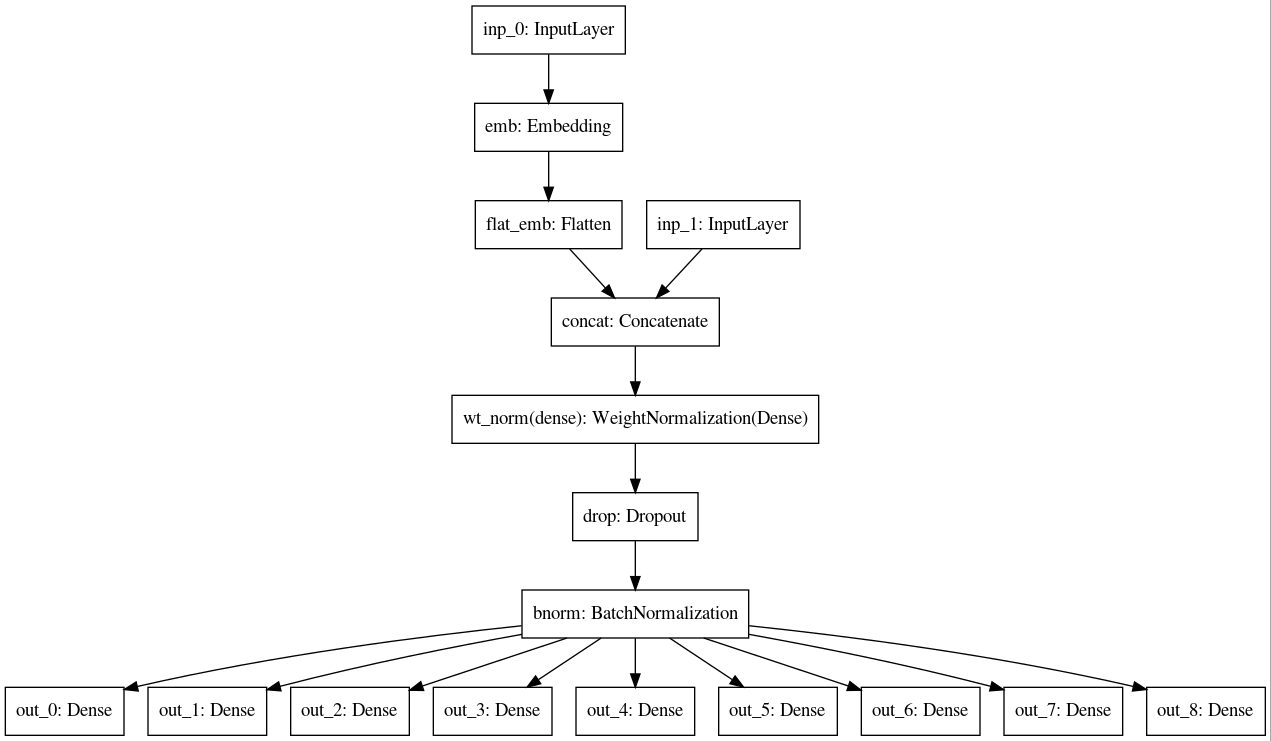

Figure 1. Schematic of the multi-class-multi-label NN architecture employed to solve the Reboot: Box-Plots for Education problem.

The code below aims to demonstrate the basic approach without focussing on software engineering. 
Some code snippets have been borrowed from Yirun Zhang's notebook https://www.kaggle.com/gogo827jz/split-neural-network-approach-tf-keras .

## Environment Set-up

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow_addons as tfa
import tensorflow.keras.backend as K

from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

from tqdm.notebook import tqdm
from time import time
import gc
import copy

print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE

tf.random.set_seed(42)

Tensorflow version 2.3.1


In [4]:
# Set IPython formatting
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)

In [5]:
XLA_ACCELERATE = True

if XLA_ACCELERATE:
    tf.config.optimizer.set_jit(True)
    print('Accelerated Linear Algebra enabled')

Accelerated Linear Algebra enabled


## Data Preprocessing

In [6]:
train = pd.read_csv('../input/sbudgets/df_train_clean_v2.csv', index_col=0)
train_y = pd.read_csv('../input/sbudgets/df_train_y.csv', index_col=0)
test = pd.read_csv('../input/sbudgets/df_test_clean_v2.csv', index_col=0)
submission = pd.read_csv('../input/sbudgets/SubmissionFormat.csv', index_col=0)

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
train.shape, test.shape

((400277, 16), (50064, 16))

In [8]:
# Numeric data preprocessing
num_cols = ['FTE', 'Total']
train_numeric = copy.deepcopy(train[num_cols])
test_numeric = copy.deepcopy(test[num_cols])

train_numeric.fillna(value=-999, axis=0, inplace=True)
test_numeric.fillna(value=-999, axis=0, inplace=True)

In [9]:
train.drop(num_cols, axis=1, inplace=True)
test.drop(num_cols, axis=1, inplace=True)

In [10]:
train.head()

,Object_Description,Text_2,SubFund_Description,Job_Title_Description,Text_3,Text_4,Sub_Object_Description,Location_Description,Function_Description,Facility_or_Department,Position_Extra,Program_Description,Fund_Description,Text_1
134338,NaN,NaN,NaN,teacher-elementary,NaN,NaN,NaN,NaN,NaN,NaN,kindergarten,kindergarten,general fund,NaN
206341,contractor services,bond expenditures,building fund,(blank),regular,NaN,NaN,NaN,region gob,NaN,undesignated,building improvement services,NaN,building improvement services
326408,personal services teachers,NaN,NaN,teacher 2nd grade,NaN,regular instruction,NaN,NaN,NaN,NaN,teacher,instruction regular,general purpose school,NaN
364634,employee benefits,teacher subsidies,general fund,teacher short term subsidy,regular,NaN,NaN,NaN,unallocated budgets/schools,NaN,professional-instructional,general middle/junior high school,NaN,regular instruction
47683,teacher coverage for teacher,teacher subsidies,general fund,teacher secondary (high),alternative,NaN,NaN,NaN,non-project,NaN,professional-instructional,general high school education,NaN,regular instruction


In [11]:
train_y.head()

,Function,Object_Type,Operating_Status,Position_Type,Pre_K,Reporting,Sharing,Student_Type,Use
134338,Teacher Compensation,NO_LABEL,PreK-12 Operating,Teacher,NO_LABEL,School,School Reported,NO_LABEL,Instruction
206341,NO_LABEL,NO_LABEL,Non-Operating,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL
326408,Teacher Compensation,Base Salary/Compensation,PreK-12 Operating,Teacher,Non PreK,School,School Reported,Unspecified,Instruction
364634,Substitute Compensation,Benefits,PreK-12 Operating,Substitute,NO_LABEL,School,School Reported,Unspecified,Instruction
47683,Substitute Compensation,Substitute Compensation,PreK-12 Operating,Teacher,NO_LABEL,School,School Reported,Unspecified,Instruction


Text(0, 0.5, 'Nunique')

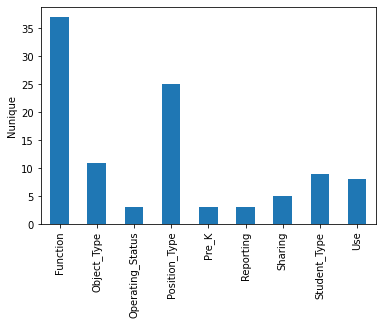

In [12]:
# Visualise the number of classes for each label
n_unique = train_y.nunique()
n_unique.plot(kind='bar')
plt.ylabel('Nunique')

In [13]:
# Set all values in the submission file to 0
submission.iloc[:, :] = 0
submission.head()

,Function__Aides Compensation,Function__Career & Academic Counseling,Function__Communications,Function__Curriculum Development,Function__Data Processing & Information Services,Function__Development & Fundraising,Function__Enrichment,Function__Extended Time & Tutoring,Function__Facilities & Maintenance,Function__Facilities Planning,"Function__Finance, Budget, Purchasing & Distribution",Function__Food Services,Function__Governance,Function__Human Resources,Function__Instructional Materials & Supplies,Function__Insurance,Function__Legal,Function__Library & Media,Function__NO_LABEL,Function__Other Compensation,Function__Other Non-Compensation,Function__Parent & Community Relations,Function__Physical Health & Services,Function__Professional Development,Function__Recruitment,Function__Research & Accountability,Function__School Administration,Function__School Supervision,Function__Security & Safety,Function__Social & Emotional,Function__Special Population Program Management & Support,Function__Student Assignment,Function__Student Transportation,Function__Substitute Compensation,Function__Teacher Compensation,Function__Untracked Budget Set-Aside,Function__Utilities,Object_Type__Base Salary/Compensation,Object_Type__Benefits,Object_Type__Contracted Services,Object_Type__Equipment & Equipment Lease,Object_Type__NO_LABEL,Object_Type__Other Compensation/Stipend,Object_Type__Other Non-Compensation,Object_Type__Rent/Utilities,Object_Type__Substitute Compensation,Object_Type__Supplies/Materials,Object_Type__Travel & Conferences,Operating_Status__Non-Operating,"Operating_Status__Operating, Not PreK-12",Operating_Status__PreK-12 Operating,Position_Type__(Exec) Director,Position_Type__Area Officers,Position_Type__Club Advisor/Coach,Position_Type__Coordinator/Manager,Position_Type__Custodian,Position_Type__Guidance Counselor,Position_Type__Instructional Coach,Position_Type__Librarian,Position_Type__NO_LABEL,Position_Type__Non-Position,Position_Type__Nurse,Position_Type__Nurse Aide,Position_Type__Occupational Therapist,Position_Type__Other,Position_Type__Physical Therapist,Position_Type__Principal,Position_Type__Psychologist,Position_Type__School Monitor/Security,Position_Type__Sec/Clerk/Other Admin,Position_Type__Social Worker,Position_Type__Speech Therapist,Position_Type__Substitute,Position_Type__TA,Position_Type__Teacher,Position_Type__Vice Principal,Pre_K__NO_LABEL,Pre_K__Non PreK,Pre_K__PreK,Reporting__NO_LABEL,Reporting__Non-School,Reporting__School,Sharing__Leadership & Management,Sharing__NO_LABEL,Sharing__School Reported,Sharing__School on Central Budgets,Sharing__Shared Services,Student_Type__Alternative,Student_Type__At Risk,Student_Type__ELL,Student_Type__Gifted,Student_Type__NO_LABEL,Student_Type__Poverty,Student_Type__PreK,Student_Type__Special Education,Student_Type__Unspecified,Use__Business Services,Use__ISPD,Use__Instruction,Use__Leadership,Use__NO_LABEL,Use__O&M,Use__Pupil Services & Enrichment,Use__Untracked Budget Set-Aside
180042,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28872,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
186915,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [14]:
# Prepare the train and test for tokenisation - each row is one string
train_joined = train.applymap(str).apply(' '.join, axis=1)
test_joined = test.applymap(str).apply(' '.join, axis=1)
train_joined.head()

134338                                                                                                                       nan nan nan teacher-elementary nan nan nan nan nan nan kindergarten kindergarten general fund nan
206341                                             contractor services bond expenditures building fund (blank) regular nan nan nan region gob nan undesignated building improvement services nan building improvement services
326408                                                                   personal services  teachers nan nan teacher 2nd grade nan regular instruction nan nan nan nan teacher instruction  regular general purpose school nan
364634    employee benefits teacher subsidies general fund teacher short term subsidy regular nan nan nan unallocated budgets/schools nan professional-instructional general middle/junior high school nan regular instruction
47683            teacher coverage for teacher teacher subsidies general fund teacher secondary (high) altern

In [15]:
# Set the parameters for tokenization and embedding
vocab_size = 30000
embedding_dim = 32
max_length = 35
trunc_type='post'
oov_tok = "<nan>"

In [16]:
# Tokenize and pad the train and test data to a fixed length
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(pd.concat([train_joined, test_joined], axis=0))

sequences = tokenizer.texts_to_sequences(train_joined)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

test_sequences = tokenizer.texts_to_sequences(test_joined)
test_padded = pad_sequences(test_sequences,maxlen=max_length)

padded[:5]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    2,    2,    2,
           7,   24,    2,    2,    2,    2,    2,    2,  211,  211,    3,
           4,    2],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0, 1050,    6,  380,  378,  124,    4,  102,    5,    2,
           2,    2, 1077,  396,    2,   35,  124,  130,    6,    2,  124,
         130,    6],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,   46,    6,   34,    2,    2,    7,  476,  247,    2,
           5,   10,    2,    2,    2,    2,    7,   10,    5,    3,   82,
           8,    2],
       [   0,    0,    0,    0,    0,    0,    0,   13,   16,    7,   91,
           3,    4,    7,   54,   52,   39,    5,    2,    2,    2,   72,
          96,   59,    2,   14,   12,    3,   69,  179,   48,    8,    2,
           5,   10],
       [   0,    0,    0,   

In [17]:
# One-hot encode y_targets for training and validation
y_list = []
y_val_list = []

for col in train_y.columns:
    y_ohe = pd.get_dummies(train_y.loc[:, col], prefix=col, prefix_sep='__')
    y_list.append(y_ohe)

y = pd.concat(y_list)

## Model Definition

In [18]:
def create_model(inp0_shape, inp1_shape, summary=False):
    
    # Inputs
    input_0 = tf.keras.Input((inp0_shape,), name='inp_0')
    input_1 = tf.keras.Input((inp1_shape,), name='inp_1')
    
    # Hidden layers
    x = tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length,
                                   name='emb')(input_0)
    x = tf.keras.layers.Flatten(name='flat_emb')(x)
    x = tf.keras.layers.Concatenate(name='concat')([x, input_1])
    x = tfa.layers.WeightNormalization(
                       tf.keras.layers.Dense(128, activation='elu', name='dense'),
                       name='wt_norm')(x)
    x = tf.keras.layers.Dropout(0.5, name='drop')(x)
    x = tf.keras.layers.BatchNormalization(name='bnorm')(x)
    
    # Outputs
    out_0 = tf.keras.layers.Dense(n_unique[0], activation='softmax', name='out_0')(x)
    out_1 = tf.keras.layers.Dense(n_unique[1], activation='softmax', name='out_1')(x)
    out_2 = tf.keras.layers.Dense(n_unique[2], activation='softmax', name='out_2')(x)
    out_3 = tf.keras.layers.Dense(n_unique[3], activation='softmax', name='out_3')(x)
    out_4 = tf.keras.layers.Dense(n_unique[4], activation='softmax', name='out_4')(x)
    out_5 = tf.keras.layers.Dense(n_unique[5], activation='softmax', name='out_5')(x)
    out_6 = tf.keras.layers.Dense(n_unique[6], activation='softmax', name='out_6')(x)
    out_7 = tf.keras.layers.Dense(n_unique[7], activation='softmax', name='out_7')(x)
    out_8 = tf.keras.layers.Dense(n_unique[8], activation='softmax', name='out_8')(x)
  
    model = tf.keras.Model(inputs=[input_0, input_1], outputs=[out_0, out_1, out_2, out_3, out_4, out_5,
                                                    out_6, out_7, out_8])
                                  
    model.compile(optimizer = tfa.optimizers.Lookahead(tf.optimizers.Adam(0.001), sync_period=10), 
                  loss='categorical_crossentropy', metrics=['accuracy'])
    if summary:
        model.summary()
    
    return model

In [19]:
def initiate_callbacks():

    rlr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 3, verbose = 0, 
                                min_delta = 5e-5, min_lr = 1e-6, mode = 'min')
        
    ckp = ModelCheckpoint('split_nn.hdf5', monitor = 'val_loss', verbose = 0, 
                              save_best_only = True, save_weights_only = True, mode = 'min')
        
    es = EarlyStopping(monitor = 'val_loss', min_delta = 1e-4, patience = 10, mode = 'min', 
                           baseline = None, restore_best_weights = True, verbose = 0)
    
    return rlr, ckp, es

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inp_0 (InputLayer)              [(None, 35)]         0                                            
__________________________________________________________________________________________________
emb (Embedding)                 (None, 35, 32)       960000      inp_0[0][0]                      
__________________________________________________________________________________________________
flat_emb (Flatten)              (None, 1120)         0           emb[0][0]                        
__________________________________________________________________________________________________
inp_1 (InputLayer)              [(None, 2)]          0                                            
_______________________________________________________________________________________

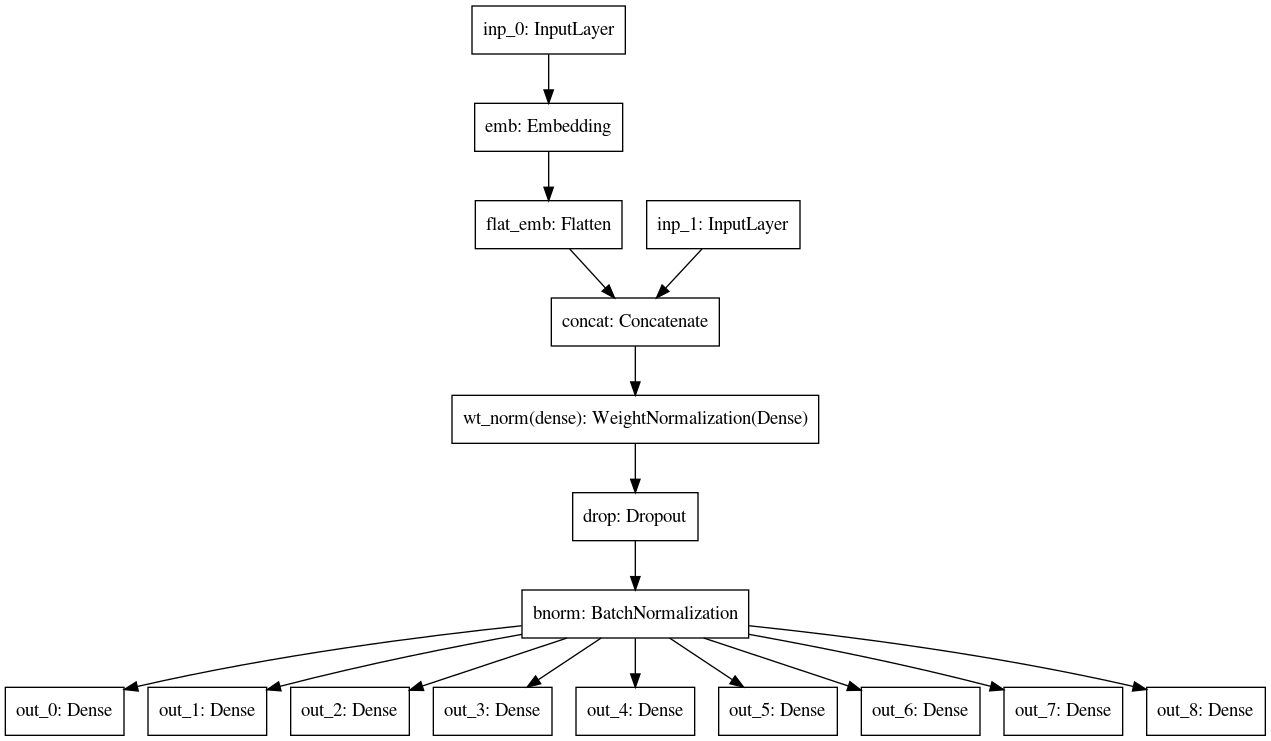

In [20]:
model = create_model(padded.shape[1], train_numeric.shape[1], summary=True)
tf.keras.utils.plot_model(model, show_shapes = False, show_layer_names= True,
                          rankdir = 'TB', expand_nested = False, dpi = 96)

## Model Training and Prediction

In [21]:
# Prepare the test input to the neural network
x_test_list = [test_padded, test_numeric]

In [22]:
%%time

# Cross-validation loop
n_fold = 1
hist_list = []
mskf = MultilabelStratifiedKFold(n_splits=10, random_state=2020, shuffle=True)

for i in range(n_fold):
    
    tr, te =  next(mskf.split(padded, train_y))
    
    x_train_list = [padded[tr, :], train_numeric.values[tr, :]]
    x_val_list = [padded[te, :], train_numeric.values[te, :]]
    y_train_list = [tar.values[tr, :] for tar in y_list]
    y_val_list = [tar.values[te, :] for tar in y_list]
    
    rlr, ckp, es = initiate_callbacks()
    model = create_model(padded.shape[1], train_numeric.shape[1], summary=False)
    
    tf.random.set_seed(i)
    history = model.fit(x_train_list, y_train_list, validation_data = (x_val_list, y_val_list), 
                        epochs = 100, batch_size = 128,
                        callbacks = [rlr, ckp, es], verbose = 0)
    
    hist_df = pd.DataFrame(history.history)
    hist_df['fold'] = i
    
    hist_list.append(hist_df)

    model.load_weights('split_nn.hdf5')
    model.save('sb_model_fold{}_seed{}.h5'.format(i, i))
    
    predictions = model.predict(x_test_list, batch_size=128)

    ss = pd.DataFrame(np.hstack(predictions), columns=submission.columns,
                      index=submission.index)
    
    submission += ss
    
    K.clear_session()
    del model, history, hist_df
    x = gc.collect()

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=2020 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


CPU times: user 2h 10min 49s, sys: 6min 30s, total: 2h 17min 19s
Wall time: 45min 18s


In [23]:
# Average the results and show the first five predictions
submission /= n_fold
submission.head()

,Function__Aides Compensation,Function__Career & Academic Counseling,Function__Communications,Function__Curriculum Development,Function__Data Processing & Information Services,Function__Development & Fundraising,Function__Enrichment,Function__Extended Time & Tutoring,Function__Facilities & Maintenance,Function__Facilities Planning,"Function__Finance, Budget, Purchasing & Distribution",Function__Food Services,Function__Governance,Function__Human Resources,Function__Instructional Materials & Supplies,Function__Insurance,Function__Legal,Function__Library & Media,Function__NO_LABEL,Function__Other Compensation,Function__Other Non-Compensation,Function__Parent & Community Relations,Function__Physical Health & Services,Function__Professional Development,Function__Recruitment,Function__Research & Accountability,Function__School Administration,Function__School Supervision,Function__Security & Safety,Function__Social & Emotional,Function__Special Population Program Management & Support,Function__Student Assignment,Function__Student Transportation,Function__Substitute Compensation,Function__Teacher Compensation,Function__Untracked Budget Set-Aside,Function__Utilities,Object_Type__Base Salary/Compensation,Object_Type__Benefits,Object_Type__Contracted Services,Object_Type__Equipment & Equipment Lease,Object_Type__NO_LABEL,Object_Type__Other Compensation/Stipend,Object_Type__Other Non-Compensation,Object_Type__Rent/Utilities,Object_Type__Substitute Compensation,Object_Type__Supplies/Materials,Object_Type__Travel & Conferences,Operating_Status__Non-Operating,"Operating_Status__Operating, Not PreK-12",Operating_Status__PreK-12 Operating,Position_Type__(Exec) Director,Position_Type__Area Officers,Position_Type__Club Advisor/Coach,Position_Type__Coordinator/Manager,Position_Type__Custodian,Position_Type__Guidance Counselor,Position_Type__Instructional Coach,Position_Type__Librarian,Position_Type__NO_LABEL,Position_Type__Non-Position,Position_Type__Nurse,Position_Type__Nurse Aide,Position_Type__Occupational Therapist,Position_Type__Other,Position_Type__Physical Therapist,Position_Type__Principal,Position_Type__Psychologist,Position_Type__School Monitor/Security,Position_Type__Sec/Clerk/Other Admin,Position_Type__Social Worker,Position_Type__Speech Therapist,Position_Type__Substitute,Position_Type__TA,Position_Type__Teacher,Position_Type__Vice Principal,Pre_K__NO_LABEL,Pre_K__Non PreK,Pre_K__PreK,Reporting__NO_LABEL,Reporting__Non-School,Reporting__School,Sharing__Leadership & Management,Sharing__NO_LABEL,Sharing__School Reported,Sharing__School on Central Budgets,Sharing__Shared Services,Student_Type__Alternative,Student_Type__At Risk,Student_Type__ELL,Student_Type__Gifted,Student_Type__NO_LABEL,Student_Type__Poverty,Student_Type__PreK,Student_Type__Special Education,Student_Type__Unspecified,Use__Business Services,Use__ISPD,Use__Instruction,Use__Leadership,Use__NO_LABEL,Use__O&M,Use__Pupil Services & Enrichment,Use__Untracked Budget Set-Aside
180042,4.957476e-06,0.016639,1.849480e-04,8.963626e-04,2.242570e-02,2.872139e-05,0.001713,0.000164,6.501493e-01,1.622950e-06,1.313120e-03,6.746124e-04,2.129057e-04,1.536291e-05,1.023493e-03,1.296347e-03,2.003810e-06,1.057675e-04,0.014550,9.488342e-06,6.195957e-03,1.139140e-03,0.000017,0.004308,8.436265e-08,5.158097e-04,0.254132,8.859172e-05,3.651063e-04,0.000971,3.642884e-05,1.978851e-05,1.024309e-03,9.604419e-06,0.000412,3.807845e-05,1.931640e-02,1.010772e-09,1.005659e-05,3.332882e-03,6.103613e-05,2.599305e-03,6.917065e-05,9.663460e-01,2.581227e-02,5.330656e-09,1.765347e-03,3.988765e-06,0.000922,0.001866,0.997212,1.258214e-06,1.282667e-08,1.916272e-07,1.874185e-04,4.607519e-05,9.613528e-06,8.567644e-07,3.673897e-07,0.997134,0.002544,5.404965e-10,2.692061e-08,2.329600e-10,0.000006,1.276442e-11,2.777901e-05,3.316398e-08,8.070973e-08,0.000019,9.206707e-09,7.499104e-09,1.286090e-07,6.096161e-08,0.000018,5.747073e-06,0.645456,0.309804,0.044740,0.003102,1.870665e-05,0.996879,2.282347e-05,0.001341,0.998631,3.93

In [24]:
submission.to_csv('sb_submission.csv', index=True)

In [25]:
# Join all the history for each fold into a single data frame
if n_fold > 1:
    hist = pd.concat(hist_list).reset_index()
else:
    hist = hist_list[0]

Text(0, 0.5, 'Loss')

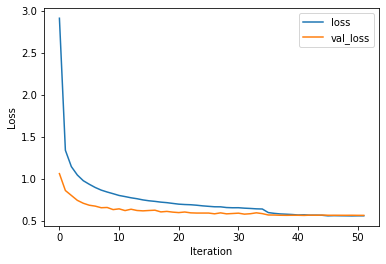

In [26]:
# Show the progression of the loss function with training
hist.groupby(['fold'])[['loss', 'val_loss']].plot()
plt.xlabel('Iteration')
plt.ylabel('Loss')

Text(0, 0.5, 'Accuracy')

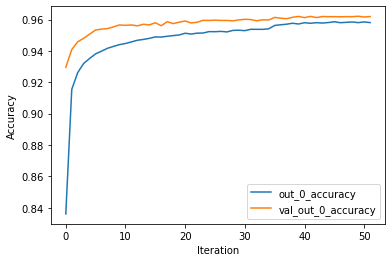

In [27]:
# Show the accuracy for the Function feature - this is the feature for 
# which the lowest accuracy is achieved
hist[['out_0_accuracy', 'val_out_0_accuracy']].plot()
plt.xlabel('Iteration')
plt.ylabel('Accuracy')

In [28]:
hist[['loss', 'val_loss']].min()

loss        0.557892
val_loss    0.563985
dtype: float64

In [29]:
hist.to_csv('history.csv')